# Mixture of Gaussians Topic Model

In [280]:
import numpy as np
import bayespy as bp
import matplotlib.pyplot as plt

from pprint import pprint
from functools import reduce

%matplotlib inline

In [295]:
# Fail fast on floating point error.
np.seterr(all="raise")
# But ignore underflow
np.seterr(under="ignore")

{'divide': 'raise', 'invalid': 'raise', 'over': 'raise', 'under': 'raise'}

## Construct Synthetic Problem

We will create an easily-identifiable synthetic dataset to verify that our algorithm behaves as we expect it. Start with a well-separated dictionary of Gaussian distributions, which we will recover.

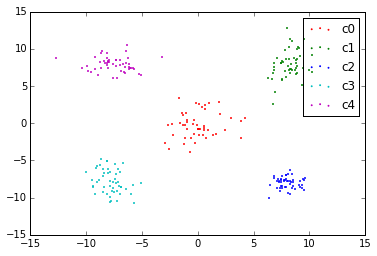

In [2]:
dictionary = [
    [np.zeros(2), 3*np.eye(2)],
    [np.array([8, 8]), np.diag([1, 3])],
    [np.array([8, -8]), np.diag([0.5, 0.5])],
    [np.array([-8, -8]), np.diag([1, 3])],
    [np.array([-8, 8]), np.diag([3, 1])]
    ]

cluster_colors = "rgbcm"

def viz_dictionary(n_samples=50):
    h = plt.figure()
    for i, (params, color) in enumerate(zip(dictionary, cluster_colors)):
        points = np.random.multivariate_normal(*params, size=n_samples)                
        
        plt.scatter(points[:,0], points[:,1], s=0.8, color=color, label="c%d" % i)
        
    plt.legend(loc='best')
    plt.xlim((-15,15))
    plt.ylim((-15,15))
        
viz_dictionary()    

Create 3 topics, one for just the center, one for the right side, and one for left side. Within each topic, bias the top half (clusters 1 and 4). Then, create 7 types of documents, one for each possible combination of topics. Bias the lower-numbered topic.

In [3]:
true_topics = np.array([
        [1.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 0.8, 0.2, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.2, 0.8]
    ])

true_document_dictionary = np.array([
        [1.0, 0.0, 0.0],
        [0.0, 1.0, 0.0],
        [0.0, 0.0, 1.0],
        [0.7, 0.3, 0.0],
        [0.7, 0.0, 0.3],
        [0.0, 0.7, 0.3],
        [0.6, 0.4, 0.2]
    ])

In [4]:
true_topics[1]

array([ 0. ,  0.8,  0.2,  0. ,  0. ])

Generate many copies of each document dictionary. Each document is 5-100 words long.

In [5]:
# Helper function
def categorical(pvals, n):
    mults = np.random.multinomial(1, pvals, n)
    return np.argmax(mults, 1)

categorical([0.1, 0.5, 0.4], 10)

array([1, 2, 1, 2, 1, 2, 1, 1, 2, 1])

49


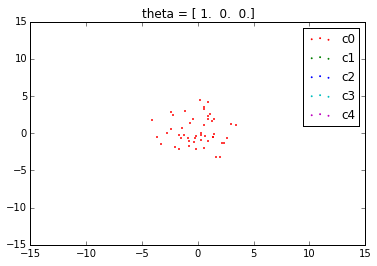

45


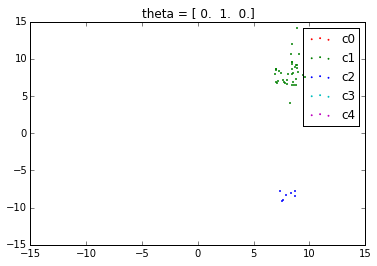

50


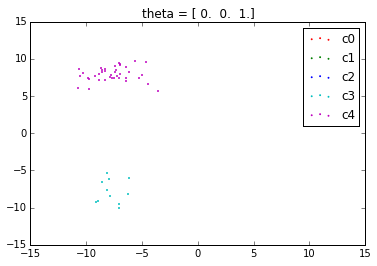

96


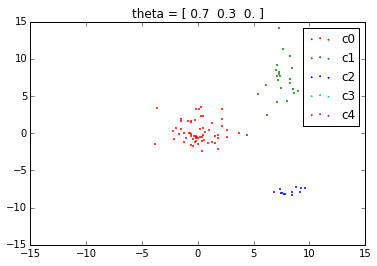

23


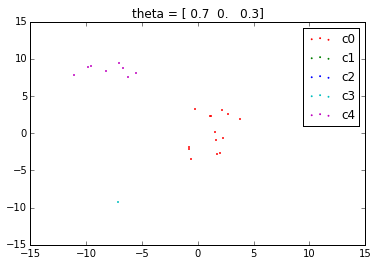

31


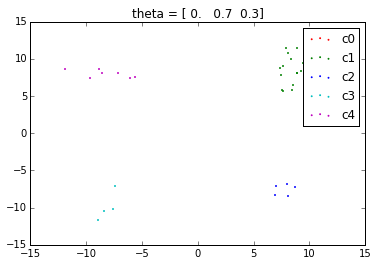

27


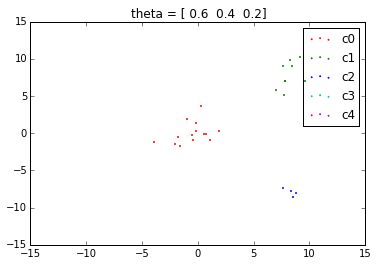

In [7]:
def sample_synthetic(copies=10, min_words=20, max_words=100, extra_dims=298):
    
    n_docs = len(true_document_dictionary) * copies    
    
    docs                     = [None] * n_docs
    true_thetas              = [None] * n_docs
    true_topic_assignments   = [None] * n_docs
    true_cluster_assignments = [None] * n_docs
    
    n = 0
    for theta in true_document_dictionary:
        for i in range(copies):
            # Copy the theta vector
            true_thetas[n] = theta
            
            # Sample the document length.
            n_words = np.random.randint(min_words, max_words + 1)
            
            # Sample the topic assignments.
            true_topic_assignments[n] = categorical(theta, n_words)
            
            # At each topic assignment, sample the cluster assignments.      
            true_cluster_assignments[n] = np.zeros(n_words)
            for k in range(len(true_topics)):
                ix = true_topic_assignments[n] == k
                true_cluster_assignments[n][ix] = categorical(true_topics[k], np.sum(ix))
            
            # At each cluster assignment, sample from the cluster.
            docs[n] = np.zeros((n_words, 2))
            for t in range(len(dictionary)):
                ix = true_cluster_assignments[n] == t
                docs[n][ix] = np.random.multivariate_normal(*dictionary[t], size=np.sum(ix))
            
            n += 1
    
    return docs, true_thetas, true_topic_assignments, true_cluster_assignments

docs, true_thetas, true_topic_assignments, true_cluster_assignments = sample_synthetic()

def viz_one_doc(doc, theta, topic_assignments, cluster_assignments):
    h = plt.figure()
    
    print(len(doc))
    
    for t in range(len(dictionary)):
        ix = cluster_assignments == t
        plt.scatter(doc[ix,0], doc[ix,1], s=0.8, color=cluster_colors[t], label="c%d" % t)
            
    plt.title("theta = %s" % theta)
    plt.legend(loc="best")
    plt.xlim((-15,15))
    plt.ylim((-15,15))
    plt.show()

    
# Plot a representative of each.
# TODO: Remove hardcoding.
for nn in range(0, 70, 10):
    viz_one_doc(docs[nn], true_thetas[nn], true_topic_assignments[nn], true_cluster_assignments[nn])

## Model Code

Run with more topics and clusters than necessary.

In [267]:
beta = vars_dict["beta"]
beta.lowerbound()

NotImplementedError: 

In [278]:
??Q.update

In [303]:
# K counts topics, T counts clusters.

# TODO: Remove the observe step; we want to use SVI.

def setup_gtm(docs, K=10, T=100, alpha=1e-6, gamma=1e-6, a=1e-6, b=1e-6):
    # Compute dimensions
    n_docs = len(docs)
    D = docs[0].shape[1]
    
    # Topic plate
    beta  = bp.nodes.Dirichlet(alpha * np.ones(T), plates=(K,), name="beta")
    beta.initialize_from_prior()
    
    # Clusters plate.
    # We implement diagonal Gaussians by using D independent Gaussians per plate.
    tau   = bp.nodes.Gamma(1e-6, 1e-6, plates=(D,T), name="tau")
    tau.initialize_from_prior()
    
    mu    = bp.nodes.GaussianARD(0, tau, plates=(D,T), name="mu")
    mu.initialize_from_prior()

    # Local variables
    thetas = [None] * n_docs
    zs     = [None] * n_docs
    cs     = [None] * n_docs
    xs     = [None] * n_docs
    
    for n in range(n_docs):
        n_words   = docs[n].shape[0]
        
        thetas[n] = bp.nodes.Dirichlet(gamma * np.ones(K), name="thetas[n]")
        thetas[n].initialize_from_prior()
        
        # The following variables are plated according to n_words.        
        zs[n]     = bp.nodes.Categorical(thetas[n], plates=(n_words,1), name="zs[n]")
        
        # The cluster assignment is a mixture of categoricals.
        cs[n]     = bp.nodes.Mixture(zs[n], bp.nodes.Categorical, beta, name="cs[n]")
        
        # Finally, the output is a mixture of Gaussians
        xs[n]     = bp.nodes.Mixture(cs[n], bp.nodes.GaussianARD, mu, tau, name="xs[n]")
    
        # This is necessary to get a finite bound prior to any mean field iterations,
        # so we can run SVI. However, you must randomize the indicators prior to the
        # first mean field iterations, or you will get garbage results.
        zs[n].initialize_from_prior()
        cs[n].initialize_from_prior()

        # vvv Evaluate the veracity of the statement below vvv
        # IMPORTANT! All the xs[n] must be observed from the get-go. Otherwise the
        # algorithm will attempt a full-covariance variational approximation.
        xs[n].observe(docs[n])        
    
    model_vars = [beta, tau, mu] + thetas + zs  + cs + xs
    
    finite_elbos = [np.isfinite(v.lower_bound_contribution()) for v in model_vars]
    assert np.all(finite_elbos), "Some variable was initialized to have infinite lower bound."
    
    if False:
        for i, v in enumerate(thetas):
            print("theta[%d] = %g" % (i, v.lower_bound_contribution()))
        for i, v in enumerate(zs):
            print("zs[%d] = %g" % (i, v.lower_bound_contribution()))
        for i, v in enumerate(cs):
            print("cs[%d] = %g" % (i, v.lower_bound_contribution()))
        
    vars_dict = { "beta": beta, 
                  "tau": tau,
                  "mu": mu,
                  "thetas": thetas,
                  "zs": zs,
                  "cs": cs,
                  "xs": xs }
    
    Q = bp.inference.VB(*model_vars)
#    print("Initial ELBO = %g" % Q.loglikelihood_lowerbound())
        
    return Q, vars_dict
    
def randomize_indicators(n):   
    vars_dict["zs"][n].initialize_from_random()
    vars_dict["cs"][n].initialize_from_random()    
    
def run_gtm_batch(Q, vars_dict, docs, max_iter=400):
    for n in range(len(docs)):
        randomize_indicators(n)
        
    Q.update(repeat=max_iter)

    # Conjugate gradients optimization FAIL. Just stick with MF instead.
#    Q.optimize(*Q.model, maxiter=max_iter, collapsed=vars_dict["zs"] + vars_dict["cs"])
#    Q.optimize(*Q.model, riemannian=True, maxiter=max_iter, collapsed=vars_dict["zs"])
    
    
# rm_params: Robbins Monro parameters. (init_step, forget, exponent)    
def run_gtm_svi(Q, vars_dict, docs, rm_params=(1e-2, 1, 0.7), n_epochs=100, n_minibatch=1, max_local_iters=10):
    Q.ignore_bound_checks = True
        
    n_docs = len(docs)
    
    mb_multiplier = n_docs / n_minibatch
    
    n_iters = int(np.ceil(n_epochs * mb_multiplier))
    
    global_vars = [vars_dict["beta"], vars_dict["tau"], vars_dict["mu"]]
        
    def local_vars_doc(n):
        return [vars_dict[name][n] for name in ["thetas", "zs", "cs", "xs"]]
    
    times_sampled = np.zeros(n_docs)
    elbos = np.zeros(n_iters)
    for t in range(n_iters):
        minibatch = np.random.choice(n_docs, size=n_minibatch, replace=False)
        new_docs  = [n for n in minibatch if times_sampled[n] == 0]
        
#        print("new_docs", new_docs)
        
        for n in new_docs:
            randomize_indicators(n)
        
        times_sampled[minibatch] += 1        
        
        local_vars = sum(map(local_vars_doc, minibatch), [])
        Q.update(*local_vars, repeat=max_local_iters, verbose=False)
                
        # SVI step
        step_sz = rm_params[0] * (t + rm_params[1]) ** (-rm_params[2])
        Q.gradient_step(*global_vars, scale=mb_multiplier * step_sz)
        
        # This will not be a good estimate...
        elbos[t] = Q.loglikelihood_lowerbound()
        
        print("SVI iter %d / %d (Epoch %d / %d), ELBO = %g" % (
                t, n_iters, np.floor(t / mb_multiplier), n_epochs, elbos[t]))

    return elbos        
        
# Pad with extra zeros to make the problem harder
# This function only works a docs matrix
def pad_vec(doc, extra_zeros):
    ret = np.zeros((doc.shape[0], doc.shape[1] + extra_zeros))
    ret[:,:doc.shape[1]] = doc
    return ret

def run_gtm_padded():
    extra_zeros = 298
    padded_docs = [pad_vec(doc, extra_zeros) for doc in docs]
    Q, vars_dict = setup_gtm(padded_docs)
    run_gtm_batch(Q, vars_dict, padded_docs)
       
Q, vars_dict = setup_gtm(docs)
#run_gtm_batch(Q, vars_dict, docs)
#run_gtm_svi(Q, vars_dict, docs, n_minibatch=69)
run_gtm_svi(Q, vars_dict, docs, n_minibatch=1)
#run_gtm_svi(Q, vars_dict, docs, n_minibatch=70)

new_docs [36]
SVI iter 0 / 7000 (Epoch 0 / 100), ELBO = -3.57663e+09
new_docs [34]
SVI iter 1 / 7000 (Epoch 0 / 100), ELBO = -3.55143e+09
new_docs []
SVI iter 2 / 7000 (Epoch 0 / 100), ELBO = -3.55143e+09
new_docs [5]
SVI iter 3 / 7000 (Epoch 0 / 100), ELBO = -3.50553e+09
new_docs [37]
SVI iter 4 / 7000 (Epoch 0 / 100), ELBO = -3.44703e+09
new_docs [67]
SVI iter 5 / 7000 (Epoch 0 / 100), ELBO = -3.40203e+09
new_docs [44]
SVI iter 6 / 7000 (Epoch 0 / 100), ELBO = -3.34353e+09
new_docs [13]
SVI iter 7 / 7000 (Epoch 0 / 100), ELBO = -3.29313e+09
new_docs [0]
SVI iter 8 / 7000 (Epoch 0 / 100), ELBO = -3.24903e+09
new_docs [31]
SVI iter 9 / 7000 (Epoch 0 / 100), ELBO = -3.18334e+09
new_docs [42]
SVI iter 10 / 7000 (Epoch 0 / 100), ELBO = -3.11224e+09
new_docs [43]
SVI iter 11 / 7000 (Epoch 0 / 100), ELBO = -3.08974e+09
new_docs [29]
SVI iter 12 / 7000 (Epoch 0 / 100), ELBO = -3.05554e+09
new_docs [55]
SVI iter 13 / 7000 (Epoch 0 / 100), ELBO = -2.97544e+09
new_docs [12]
SVI iter 14 / 7000 (

array([ -3.57663365e+09,  -3.55143365e+09,  -3.55143357e+09, ...,
        -3.92980789e+04,  -3.92980789e+04,  -3.92980789e+04])

## Analyze Posterior

First sanity check is to visualize the GMM.

In [304]:
def posterior_mean_assigns_doc(vars_dict, n):
    mean_zs = np.mean(np.squeeze(vars_dict["zs"][n].get_moments()[0], 1), 0)
    mean_cs = np.mean(np.squeeze(vars_dict["cs"][n].get_moments()[0], 1), 0)
    
    return (mean_zs, mean_cs)

def posterior_mean_assigns(vars_dict):
    doc_mean_zs_tup, doc_mean_cs_tup = list(zip(*[posterior_mean_zs_cs(vars_dict, n) for n in range(len(docs))]))
    doc_mean_zs = np.vstack(doc_mean_zs_tup)
    doc_mean_cs = np.vstack(doc_mean_cs_tup)
    
    return doc_mean_zs, doc_mean_cs

The clusters seem to be well-recovered, but the topics not so much.

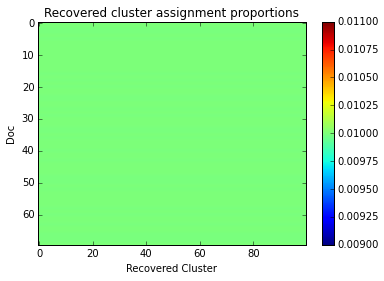

Cluster 0, Fraction 0.01
Mean     : [ 1.05409428  2.71774746]
Variance : [ 38.58465473  32.30004325]
Cluster 1, Fraction 0.01
Mean     : [ 1.05409428  2.71774746]
Variance : [ 38.58465473  32.30004325]
Cluster 2, Fraction 0.01
Mean     : [ 1.05409428  2.71774746]
Variance : [ 38.58465473  32.30004325]
Cluster 3, Fraction 0.01
Mean     : [ 1.05409428  2.71774746]
Variance : [ 38.58465473  32.30004325]
Cluster 4, Fraction 0.01
Mean     : [ 1.05409428  2.71774746]
Variance : [ 38.58465473  32.30004325]
Cluster 5, Fraction 0.01
Mean     : [ 1.05409428  2.71774746]
Variance : [ 38.58465473  32.30004325]
Cluster 6, Fraction 0.01
Mean     : [ 1.05409428  2.71774746]
Variance : [ 38.58465473  32.30004325]
Cluster 7, Fraction 0.01
Mean     : [ 1.05409428  2.71774746]
Variance : [ 38.58465473  32.30004325]
Cluster 8, Fraction 0.01
Mean     : [ 1.05409428  2.71774746]
Variance : [ 38.58465473  32.30004325]
Cluster 9, Fraction 0.01
Mean     : [ 1.05409428  2.71774746]
Variance : [ 38.58465473  32.

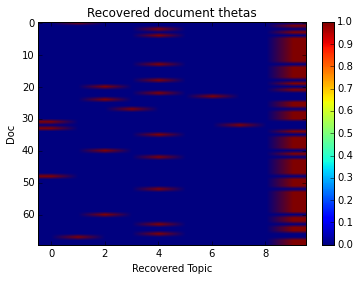

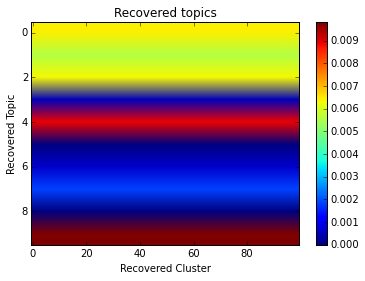

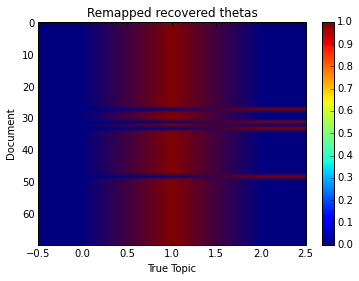

{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 0, 68: 0, 69: 0, 70: 0, 71: 0, 72: 0, 73: 0, 74: 0, 75: 0, 76: 0, 77: 0, 78: 0, 79: 0, 80: 0, 81: 0, 82: 0, 83: 0, 84: 0, 85: 0, 86: 0, 87: 0, 88: 0, 89: 0, 90: 0, 91: 0, 92: 0, 93: 0, 94: 0, 95: 0, 96: 0, 97: 0, 98: 0, 99: 0} {0: 2, 1: 1, 2: 1, 3: 2, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0, 9: 1} [[ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  1

In [305]:
# match maps dimension in v to dimension in output.
def remap(in_v, match):
    out_dim = max(match.values()) + 1
    out_v   = np.zeros(out_dim)
    
    for in_i, out_i in match.items():
        out_v[out_i] += in_v[in_i]
        
    return out_v    

def plot_nonempty_clusters(vars_dict):   
    doc_mean_zs, doc_mean_cs = posterior_mean_assigns(vars_dict)
    total_mean_clusters      = np.mean(doc_mean_cs, 0)
    nonempty_clusters        = np.flatnonzero(total_mean_clusters)
            
    total_mean_topics        = np.mean(doc_mean_zs, 0)

    # Cluster stuff
    plt.figure()
    plt.imshow(doc_mean_cs, aspect="auto")
    plt.colorbar()
    plt.xlabel("Recovered Cluster")
    plt.ylabel("Doc")
    plt.title("Recovered cluster assignment proportions")             
    plt.show()
    
    cluster_match = {}
    
    for t in nonempty_clusters:
        t = int(t) # NumPy, you are stupid.
        
        means = vars_dict["mu"][:,t].get_moments()[0]
        
        print("Cluster %d, Fraction %g" % (t, total_mean_clusters[t]))
        print("Mean     : %s"      % means)
        print("Variance : %s" % (1.0 / vars_dict["tau"][:,t].get_moments()[0]))
        
        # Match with a dictionary
        dists = []
        for t_true, params_true in enumerate(dictionary):
            dists.append(np.linalg.norm(means - params_true[0]))
        
        cluster_match[t] = np.argmin(dists)
    
    # TODO: Match topics to ground truth.
    
    # Topic stuff
    plt.figure()
    plt.imshow(doc_mean_zs, aspect="auto")
    plt.colorbar()
    plt.xlabel("Recovered Topic")
    plt.ylabel("Doc")
    plt.title("Recovered document thetas")                
    plt.show()
        
    # The actual topic
    beta_mean = np.exp(vars_dict["beta"].get_moments()[0])
    plt.figure()
    plt.imshow(beta_mean, aspect="auto")
    plt.xlabel("Recovered Cluster")
    plt.ylabel("Recovered Topic")
    plt.title("Recovered topics")
    plt.colorbar()
    plt.show()
    
    # Iterate rows of the recovered topics
    n_true_clusters = len(dictionary)
    topic_match = {}
    for k, recovered_topic in enumerate(beta_mean):        
        mapped_topic = remap(recovered_topic, cluster_match)
            
        # Find the nearest L1 norm true topic        
        dists = []
        for k_true, true_topic in enumerate(true_topics):
            dists.append(np.linalg.norm(mapped_topic - true_topic, 1))
        
#        print(dists)
        topic_match[k] = np.argmin(dists)
    
    n_docs        = doc_mean_zs.shape[0]
    n_true_topics = max(topic_match.values()) + 1       
    mapped_thetas  = np.zeros((n_docs, n_true_topics))
    
    for n, recovered_theta in enumerate(doc_mean_zs):
        mapped_thetas[n,:] = remap(recovered_theta, topic_match)
            
    plt.figure()
    plt.imshow(mapped_thetas, aspect="auto")
    plt.xlabel("True Topic")
    plt.ylabel("Document")
    plt.title("Remapped recovered thetas")
    plt.colorbar()
    plt.show()    
            
    return cluster_match, topic_match, mapped_thetas
        
# Map the recovered cluster id to the true cluster id.    
cluster_match, topic_match, mapped_thetas = plot_nonempty_clusters(vars_dict)
print (cluster_match, topic_match, mapped_thetas)

Eventually look at the recovered theta values, but for now, I have good enough assurance.

In [ ]:
def var_to_categorical(v):    
    return np.argmax(np.squeeze(v.get_moments()[0], 1), 1)

def compute_global_stats(vars_dict, docs, K=10, T=100):
    n_docs = len(docs)
    
    topic_counts   = np.zeros(K)
    cluster_counts = np.zeros(T)    
    
    for n in range(n_docs):
        
    
    

In [23]:
def plot_post_one_doc(vars_dict, n):
    print("Doc %d has %d vecs." % (n, len(docs[n])))
    c = np.argmax(np.squeeze(vars_dict["cs"][n].get_moments()[0], 1), 1)
    print(c)
#    print(np.sum(c, 0))
    
    print(np.exp(vars_dict["thetas"][n].get_moments()[0]))
    
plot_post_one_doc(vars_dict, 11)

Doc 11 has 82 vecs.
[68 68 12 12 68 68 68 68 68 68 68 68 12 68 12 68 68 68 68 68 68 68 68 68 68
 68 68 68 68 68 12 68 68 68 68 68 68 68 68 68 68 12 12 68 12 68 12 12 68 68
 68 68 68 12 68 68 68 68 68 68 12 12 68 68 68 68 68 12 68 68 68 68 12 68 68
 12 68 12 68 68 68 68]
[ 0.9867163   0.          0.          0.          0.00783108  0.          0.
  0.          0.          0.        ]


In [18]:
len(docs)

70

In [10]:
np.argmax(np.squeeze(vars_dict["cs"][65].get_moments()[0], 1), 1)

array([68, 50, 50, 68, 50, 50, 68, 68, 50, 50, 50, 68, 50, 68, 68, 50, 50,
       50, 68, 50, 50, 68, 50, 50, 50, 12, 68, 50, 12, 50, 50, 50, 50, 68,
       50, 50, 68, 12, 68, 68, 12, 50, 50, 68, 68, 50, 50, 68, 50, 50, 50,
       68, 50, 50, 68, 50, 68, 50, 68, 50, 68, 50, 50, 50, 50, 50, 12])

In [11]:
vars_dict["thetas"][0]

In [12]:
thetas = vars_dict["thetas"]

In [13]:
np.exp(thetas[0].get_moments()[0])

array([ 0.        ,  0.        ,  0.99999814,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [14]:
t1 = thetas[0]
t1.get_parameters()

[array([  1.00000000e-05,   1.00000000e-05,   4.90000100e+01,
          1.00000000e-05,   1.00000000e-05,   1.00000000e-05,
          1.00000000e-05,   1.00000000e-05,   1.00000000e-05,
          1.00000000e-05])]

Moments are $E[\log X]$. This is confirmed by the documentation http://www.bayespy.org/dev_api/generated/generated/bayespy.inference.vmp.nodes.dirichlet.DirichletDistribution.compute_moments_and_cgf.html#bayespy.inference.vmp.nodes.dirichlet.DirichletDistribution.compute_moments_and_cgf. (I think it's because whenever Dirichlet is used in VB, only $E[\log X]$ is used, not $E[X]$. (However, categoricals use the true moments.)

In [15]:
import scipy as sp
np.allclose(
    sp.special.psi(t1.get_parameters()) - sp.special.psi(np.sum(t1.get_parameters())),
    t1.get_moments()[0]
    )

True

In [16]:
t1.get_moments()[0]

array([ -1.00004459e+05,  -1.00004459e+05,  -1.85560227e-06,
        -1.00004459e+05,  -1.00004459e+05,  -1.00004459e+05,
        -1.00004459e+05,  -1.00004459e+05,  -1.00004459e+05,
        -1.00004459e+05])

In [17]:
def recover_clusters(zs):
    max_k = np.max(zs)
    clusters = []
    for k in range(max_k):
        ix = zs == k
        Nk = np.sum(ix)
        if Nk > 0:
            clusters.append(set(np.flatnonzero(ix)))
    
    return clusters